# Predicting Dry Beans Varieties through XGBoost model

Within this notebook we will explore the preprocessed dry beans data that was an ouput from our 'DryBeans_Flow_lcmhng.flow' notebook and from there test, train, and evaluate an XGBoost classifier model to predict the endpoint of the bean type.

**Dataset Features**
The DryBeans dataset contains 17 features. 
16 will be used for training the model
1 is the class of the bean of which there are 7 varieties to see.

    1.) Area (A): The area of a bean zone and the number of pixels within its boundaries.
    2.) Perimeter (P): Bean circumference is defined as the length of its border.
    3.) Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.
    4.) Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
    5.) Aspect ratio (K): Defines the relationship between L and l.
    6.) Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.
    7.) Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
    8.) Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.
    9.) Extent (Ex): The ratio of the pixels in the bounding box to the bean area.
    10.)Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
    11.)Roundness (R): Calculated with the following formula: (4piA)/(P^2)
    12.)Compactness (CO): Measures the roundness of an object: Ed/L
    13.)ShapeFactor1 (SF1)
    14.)ShapeFactor2 (SF2)
    15.)ShapeFactor3 (SF3)
    16.)ShapeFactor4 (SF4)
    17.)Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)
    
**Additionally, though it was completed in a previous notebook, we will incorporate our work from the .flow work earlier in this notebook**

In [2]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.dataset_definition.inputs import AthenaDatasetDefinition, DatasetDefinition, RedshiftDatasetDefinition

data_sources = []

## Input - S3 Source: Dry_Bean_Dataset.csv

Already accomplished, but capturing the idea behind cleaning again

In [3]:
data_sources.append(ProcessingInput(
    source="s3://lcmhng-sagemaker/Dry_Bean_Dataset.csv", # You can override this to point to other dataset on S3
    destination="/opt/ml/processing/Dry_Bean_Dataset.csv",
    input_name="Dry_Bean_Dataset.csv",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type="FullyReplicated"
))

## Output: S3 settings

In [4]:
import time
import uuid
import sagemaker

# Sagemaker session
sess = sagemaker.Session()

# You can configure this with your own bucket name, e.g.
# bucket = "my-bucket"
bucket = sess.default_bucket()
print(f"Data Wrangler export storage bucket: {bucket}")

# unique flow export ID
flow_export_id = f"{time.strftime('%d-%H-%M-%S', time.gmtime())}-{str(uuid.uuid4())[:8]}"
flow_export_name = f"flow-{flow_export_id}"

Data Wrangler export storage bucket: sagemaker-us-east-1-714861692883


Below are the inputs required by the SageMaker Python SDK to launch a processing job.

In [5]:
# Output name is auto-generated from the select node's ID + output name from the flow file.
output_name = "75364914-39e6-49df-8ad7-3ed82a6419d7.default"

s3_output_prefix = f"export-{flow_export_name}/output"
s3_output_path = f"s3://{bucket}/{s3_output_prefix}"
print(f"Flow S3 export result path: {s3_output_path}")

processing_job_output = ProcessingOutput(
    output_name=output_name,
    source="/opt/ml/processing/output",
    destination=s3_output_path,
    s3_upload_mode="EndOfJob"
)

Flow S3 export result path: s3://sagemaker-us-east-1-714861692883/export-flow-22-18-26-23-77b051f9/output


## Upload Flow to S3

To use the Data Wrangler as an input to the processing job,  first upload your flow file to Amazon S3.

In [6]:
import os
import json
import boto3

# name of the flow file which should exist in the current notebook working directory
flow_file_name = "DryBeans_Flow_lcmhng.flow"

# Load .flow file from current notebook working directory 
!echo "Loading flow file from current notebook working directory: $PWD"

with open(flow_file_name) as f:
    flow = json.load(f)

# Upload flow to S3
s3_client = boto3.client("s3")
s3_client.upload_file(flow_file_name, bucket, f"data_wrangler_flows/{flow_export_name}.flow", ExtraArgs={"ServerSideEncryption": "aws:kms"})

flow_s3_uri = f"s3://{bucket}/data_wrangler_flows/{flow_export_name}.flow"

print(f"Data Wrangler flow {flow_file_name} uploaded to {flow_s3_uri}")

Loading flow file from current notebook working directory: /root/amazon-sagemaker-examples/aws_sagemaker_studio/getting_started
Data Wrangler flow DryBeans_Flow_lcmhng.flow uploaded to s3://sagemaker-us-east-1-714861692883/data_wrangler_flows/flow-22-18-26-23-77b051f9.flow


The Data Wrangler Flow is also provided to the Processing Job as an input source which we configure below.

In [7]:
## Input - Flow: DryBeans_Flow_lcmhng.flow
flow_input = ProcessingInput(
    source=flow_s3_uri,
    destination="/opt/ml/processing/flow",
    input_name="flow",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type="FullyReplicated"
)

# Run Processing Job 
## Job Configurations


In [8]:
# IAM role for executing the processing job.
iam_role = sagemaker.get_execution_role()

# Unique processing job name. Give a unique name every time you re-execute processing jobs
processing_job_name = f"data-wrangler-flow-processing-{flow_export_id}"

# Data Wrangler Container URL.
container_uri = "663277389841.dkr.ecr.us-east-1.amazonaws.com/sagemaker-data-wrangler-container:1.x"
# Pinned Data Wrangler Container URL. 
container_uri_pinned = "663277389841.dkr.ecr.us-east-1.amazonaws.com/sagemaker-data-wrangler-container:1.14.3"

# Processing Job Instance count and instance type.
instance_count = 2
instance_type = "ml.m5.4xlarge"

# Size in GB of the EBS volume to use for storing data during processing
volume_size_in_gb = 30

# Content type for each output. Data Wrangler supports CSV as default and Parquet.
output_content_type = "CSV"

# Network Isolation mode; default is off
enable_network_isolation = False

# List of tags to be passed to the processing job
user_tags = []

# Output configuration used as processing job container arguments 
output_config = {
    output_name: {
        "content_type": output_content_type
    }
}

# KMS key for per object encryption; default is None
kms_key = None

## Create Processing Job

To launch a Processing Job, we will use the SageMaker Python SDK to create a Processor function.

In [9]:
from sagemaker.processing import Processor
from sagemaker.network import NetworkConfig

processor = Processor(
    role=iam_role,
    image_uri=container_uri,
    instance_count=instance_count,
    instance_type=instance_type,
    volume_size_in_gb=volume_size_in_gb,
    network_config=NetworkConfig(enable_network_isolation=enable_network_isolation),
    sagemaker_session=sess,
    output_kms_key=kms_key,
    tags=user_tags
)

# Start Job
processor.run(
    inputs=[flow_input] + data_sources, 
    outputs=[processing_job_output],
    arguments=[f"--output-config '{json.dumps(output_config)}'"],
    wait=False,
    logs=False,
    job_name=processing_job_name
)


Job Name:  data-wrangler-flow-processing-22-18-26-23-77b051f9
Inputs:  [{'InputName': 'flow', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/data_wrangler_flows/flow-22-18-26-23-77b051f9.flow', 'LocalPath': '/opt/ml/processing/flow', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'Dry_Bean_Dataset.csv', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://lcmhng-sagemaker/Dry_Bean_Dataset.csv', 'LocalPath': '/opt/ml/processing/Dry_Bean_Dataset.csv', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': '75364914-39e6-49df-8ad7-3ed82a6419d7.default', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/export-flow-22-18-26-23-77b051f9/output', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


## Job Status & S3 Output Location

Below you wait for processing job to finish. If it finishes successfully, the raw parameters used by the 
Processing Job will be printed

In [10]:
s3_job_results_path = f"s3://{bucket}/{s3_output_prefix}/{processing_job_name}"
print(f"Job results are saved to S3 path: {s3_job_results_path}")

job_result = sess.wait_for_processing_job(processing_job_name)
job_result

Job results are saved to S3 path: s3://sagemaker-us-east-1-714861692883/export-flow-22-18-26-23-77b051f9/output/data-wrangler-flow-processing-22-18-26-23-77b051f9
.....................................................................................!

{'ProcessingInputs': [{'InputName': 'flow',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/data_wrangler_flows/flow-22-18-26-23-77b051f9.flow',
    'LocalPath': '/opt/ml/processing/flow',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'Dry_Bean_Dataset.csv',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://lcmhng-sagemaker/Dry_Bean_Dataset.csv',
    'LocalPath': '/opt/ml/processing/Dry_Bean_Dataset.csv',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': '75364914-39e6-49df-8ad7-3ed82a6419d7.default',
    'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/export-flow-22-18-26-23-77b051f9/output',
     'LocalPath': '/opt/ml/processing/output',
     'S3UploadMode': 'EndOfJob'},
    

# Load Processed Data into Pandas

From here, we will begin new work to prep for our classification model and validation of the model

In [11]:
!pip install -q awswrangler pandas
import awswrangler as wr

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [16]:
chunksize = 14000

if output_content_type.upper() == "CSV":
    dfs = wr.s3.read_csv(s3_output_path, chunksize=chunksize)
elif output_content_type.upper() == "PARQUET":
    dfs = wr.s3.read_parquet(s3_output_path, chunked=chunksize)
else:
    print(f"Unexpected output content type {output_content_type}") 

df = next(dfs)
df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653247,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [13]:
run_optional_steps = False

if not run_optional_steps:
    raise SystemExit("Stop here. Do not automatically execute optional steps.")

SystemExit: Stop here. Do not automatically execute optional steps.

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Data Exploration Graph

Let's take a quick look at distribution of the bean types

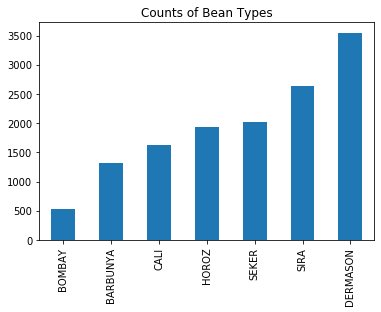

In [17]:
df['Class'].value_counts().sort_values().plot(kind="bar", title="Counts of Bean Types")

# Prep data for modeling

In [20]:
# Split dataframe into a random sample of train_data, test_data
# Create train/test split than recombine below

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

df_features = df.drop('Class', axis=1)
df_class = df['Class']

X_train, X_test, y_train, y_test = train_test_split(df_features, df_class, test_size=.2)


In [24]:
import pandas as pd
import numpy as np

def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([y_train, X_train], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data = pd.concat([y_test, X_test], axis=1)
testing_data, _ = number_encode_features(testing_data)
test_features = X_test
test_target = y_test
test_features.to_csv("test_features.csv", index=False, header=False)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [25]:
training_data.head()

,Class,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
13465,3,40390,729.154,258.937013,199.153179,1.300190,0.639107,40689,226.773334,0.742682,0.992652,0.954652,0.875786,0.006411,0.002326,0.767001,0.997247
10806,3,27920,618.669,235.339690,151.392187,1.554504,0.765621,28181,188.544022,0.737688,0.990738,0.916661,0.801157,0.008429,0.002142,0.641852,0.997762
1358,5,41376,733.668,260.746951,202.357239,1.288548,0.630650,41678,229.524638,0.762494,0.992754,0.965960,0.880258,0.006302,0.002334,0.774854,0.998437
8474,6,43377,789.870,295.439811,187.742355,1.573645,0.772128,43967,235.009174,0.694043,0.986581,0.873692,0.795455,0.006811,0.001682,0.632749,0.995723
7004,4,59349,970.156,389.854250,195.674781,1.992358,0.864915,60182,274.891786,0.805060,0.986159,0.792392,0.705114,0.006569,0.001002,0.497186,0.990573


In [27]:
# Upload to S3 before training
from sagemaker import Session

session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/Project-sagemaker-clarify"
region = session.boto_region_name
# Define IAM role
from sagemaker import get_execution_role
import os
import boto3

role = get_execution_role()
s3_client = boto3.client("s3")


from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))

# Begin training model

I continue to get errors in this part of the code and I cannot find out why

In [41]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="latest")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
#    max_depth=5,
#    eta=0.2,
#    gamma=4,
#    min_child_weight=6,
#    subsample=0.8,
    objective="multi:softmax",
    num_class=7,
    num_round=500
)

xgb.fit({"train": train_input}, logs=False)


2022-04-22 19:59:36 Starting - Starting the training job....
2022-04-22 19:59:57 Starting - Preparing the instances for training............
2022-04-22 20:01:06 Downloading - Downloading input data....
2022-04-22 20:01:31 Training - Downloading the training image.......
2022-04-22 20:02:07 Training - Training image download completed. Training in progress.....
2022-04-22 20:02:33 Uploading - Uploading generated training model
2022-04-22 20:02:38 Completed - Training job completed


# Next we bring in Clarify from Sage Maker to assess the model

In [45]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

In [42]:
# Create the sagemaker model

model_name = "Project-clarify-model-lcmhng"
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

'Project-clarify-model-lcmhng'

# Detecting bias in the model with Clarify

In [53]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="Class",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [54]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

# Generating predictions and Write Bias Config

In [55]:
# Predictions

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

In [56]:
# Writing BiasConfig

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[7], facet_name="Area", facet_values_or_threshold=[0], group_name="roundness"
)

# Compute the Post-Training Bias

This one always produces a lot of output to review

In [57]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2022-04-22-20-13-56-354
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/Project-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/Project-sagemaker-clarify/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/Project-sagemaker-clarify/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
..

UnexpectedStatusException: Error for Processing job Clarify-Bias-2022-04-22-20-13-56-354: Failed. Reason: ClientError: Predicted Label Column series datatype is not the same as Label Column series


In [59]:
# Get saved bias report path for further review

bias_report_output_path

's3://sagemaker-us-east-1-714861692883/sagemaker/Project-sagemaker-clarify/clarify-bias'

# Next we will Explain Predictions similar to the clarify practices

In [58]:
shap_config = clarify.SHAPConfig(
    baseline=[test_features.iloc[0].values.tolist()],
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="Class",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [60]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2022-04-22-20-22-51-510
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/Project-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/Project-sagemaker-clarify/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/Project-sagemaker-clarify/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S

In [61]:
# Get ouput path

explainability_output_path

's3://sagemaker-us-east-1-714861692883/sagemaker/Project-sagemaker-clarify/clarify-explainability'

In [63]:
!pip install s3fs

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 54 kB 535 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 8.1 MB 49.7 MB/s            
  Created wheel for aiobotocore: filename=aiobotocore-2.0.1-py3-none-any.whl size=51993 sha256=bbb41460b9688af9f9d675ef48fec08da5324e867beb1e087abf7b45e6562b73
  Stored in directory: /root/.cache/pip/wheels/56/cd/99/917ef1080ec8cc6f1c903f4622761689c3886bc49306855a0e
Successfully built aiobotocore
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.45
    Uninstalling botocore-1.24.45

In [64]:
# Analysis of local explanations
import s3fs

local_explanations_out = pd.read_csv(explainability_output_path + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature values -- Label", training_data.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=90
)

AttributeError: 'AioClientCreator' object has no attribute '_register_lazy_block_unknown_fips_pseudo_regions'

# Assuming we need to clean up resources

In [65]:
session.delete_model(model_name)